<a href="https://colab.research.google.com/github/aperrier004/video-analysis/blob/main/Video_Analysis_PERRIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author : Alban PERRIER - ENSC (Bordeaux INP) 2021

Video Analysis Project - Boris MANSENCAL

# Setup

Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installation modules

In [ ]:
#!pip install tensorflow

# Data Generation and Processing

In [ ]:
import os
base_dir = "/content/drive/MyDrive/ENSC/3A/[C] Applications de l'Intelligence Artificielle/Analyse Vidéo/DB"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "test")

Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Rescaling images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# transform the pixel value from a range [0,255 ] to [0,1] to behave all images the same

total_img_train = 4736
total_img_test = 3568

batch_size = 16 # PGCD(total_img_train,total_img_test)
train_steps = total_img_train / batch_size
test_steps = total_img_test / batch_size

epochs = 30

# Flow training images in batches of 20
train_generator = train_datagen.flow_from_directory(
    train_dir, # source for the training images
    target_size=(256,256), # resizing images
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches of 8
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(256,256),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical'
)



Found 4736 images belonging to 5 classes.
Found 3568 images belonging to 5 classes.


TODO : Regarder l'influence du batch size

Model Design

In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(256,256,3)),
    tf.keras.layers.Conv2D(16, (3,3), activation="relu"),

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation="relu"),
    #tf.keras.layers.Dropout((0.2)),
    tf.keras.layers.Dense(5, activation="softmax")
])

Model Training

In [ ]:
model.summary()
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                    

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps, # total images = batch_size * steps
    epochs=epochs, 
    validation_data=validation_generator,
    validation_steps=test_steps # total images = batch_size * steps 
) # 28min d'exécution

Epoch 1/30
296/296 [==============================] - 93s 314ms/step - loss: 0.9822 - accuracy: 0.7010 - val_loss: 1.0714 - val_accuracy: 0.6107
Epoch 2/30
296/296 [==============================] - 62s 209ms/step - loss: 0.6872 - accuracy: 0.7967 - val_loss: 0.9971 - val_accuracy: 0.6544
Epoch 3/30
296/296 [==============================] - 62s 209ms/step - loss: 0.4961 - accuracy: 0.8585 - val_loss: 0.8700 - val_accuracy: 0.6951
Epoch 4/30
296/296 [==============================] - 62s 208ms/step - loss: 0.3813 - accuracy: 0.8970 - val_loss: 0.8154 - val_accuracy: 0.7267
Epoch 5/30
296/296 [==============================] - 61s 206ms/step - loss: 0.2987 - accuracy: 0.9240 - val_loss: 0.8274 - val_accuracy: 0.7464
Epoch 6/30
296/296 [==============================] - 60s 202ms/step - loss: 0.2507 - accuracy: 0.9407 - val_loss: 0.7948 - val_accuracy: 0.7719
Epoch 7/30
296/296 [==============================] - 59s 201ms/step - loss: 0.2034 - accuracy: 0.9521 - val_loss: 0.8090 - val_ac

# Evaluation of the model

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, test_steps)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[403  29 104  26   3]
 [ 26 577  12  23  33]
 [ 62   0 545  21  14]
 [ 98  17  65 686  11]
 [  1  24  47  24 717]]


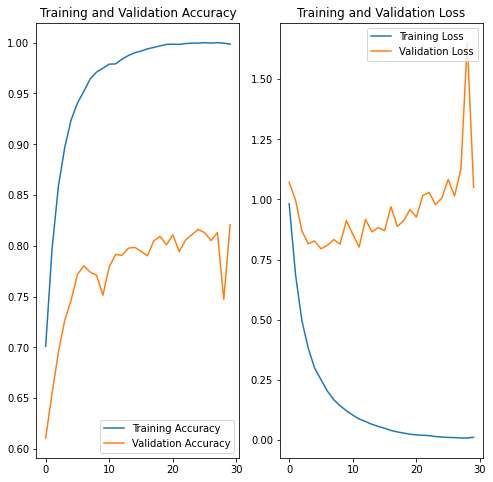

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()